In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np
from numpy import random
database = 'database.sqlite'
conn = sqlite3.connect('../../database/database.sqlite')
sql = """select league_id,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A from Match where league_id=21518 or league_id= 1729 or league_id=4769 or league_id=10257"""                  

data = pd.read_sql(sql,conn)

#Converting season values

def change_season(match):
    if match['season'] =='2008/2009':
        return 0
    elif match['season'] =='2009/2010':
        return 1
    elif match['season'] =='2010/2011':
        return 2
    elif match['season'] =='2011/2012':
        return 3
    elif match['season'] =='2012/2013':
        return 4
    elif match['season'] =='2013/2014':
        return 5
    elif match['season'] =='2014/2015':
        return 6
    else:
        return 7
    
data['season']=data.apply(change_season, axis=1) 

#Classifing Match output
def determine_home_result(match):
    if match['home_team_goal'] > match['away_team_goal']:
        return 1
    elif match['home_team_goal'] < match['away_team_goal']:
        return 2
    else:
        return 0
    
    
data['Output']=data.apply(determine_home_result, axis=1)

data= data.dropna()

train_value = 4
val_value = 5
test_value = 6

from sklearn.metrics import log_loss


train = data[data['season']<=train_value]
val = data[data['season']==val_value]
test = data[data['season']>=test_value]

ft_raw=['league_id','season','stage','home_team_api_id','away_team_api_id','B365H','B365D','B365A']
out='Output'

Vamos conhecer melhor a nossa distribuição das classes

In [13]:
val['Output'].value_counts()

1    707
2    451
0    362
Name: Output, dtype: int64

In [2]:
tot = data['Output'].value_counts()
#tot =  (v*1./np.sum(tot)) for v in tot
total=[]
for v in range(len(tot)):
    total.append((tot[v]*1./np.sum(tot)))
print total
print "Train"
tot_train=[]
for v in range(len(train[out].value_counts())):
    tot_train.append((train[out].value_counts()[v]*1./np.sum(train[out].value_counts())))
print tot_train
print "Val"
tot_val=[]
for v in range(len(val['Output'].value_counts())):
    tot_val.append((val['Output'].value_counts()[v]*1./np.sum(val[out].value_counts())))
print tot_val
print "Test"
tot_test=[]
for v in range(len(test[out].value_counts())):
    tot_test.append((test[out].value_counts()[v]*1./np.sum(test[out].value_counts())))
print tot_test


[0.25886524822695034, 0.46453900709219859, 0.27659574468085107]
Train
[0.26215644820295986, 0.47238372093023256, 0.26545983086680763]
Val
[0.2381578947368421, 0.4651315789473684, 0.29671052631578948]
Test
[0.26102699144173797, 0.4447004608294931, 0.29427254772876893]


Vamos agora definir as funções de treinamento e validação dos algoritmos que serão testados nesse trabalho.

In [5]:
from sklearn import linear_model
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

C= [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag']
n = range(100,1000,50)
lr= [0.0001, 0.001, 0.01, 0.1]
k = range(1,100,2)
knn_algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']


def pca_logreg_validation(C,solver,train,val,train_y,val_y):
    sc_max = -10000
    best=[]
    for s in solver:
        for cv in C:
            lg = linear_model.LogisticRegression(C=cv,solver=s,n_jobs=-1,max_iter=100000)
            lg.fit(train,train_y)
            score = f1_score(val_y, lg.predict(val),average='weighted')
            if score>sc_max:
                best=lg
                sc_max=score
    return best
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def pca_rf_validation(n_estimators,train,val,train_y,val_y):
    sc_max = -10000
    best=[]
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators=n,n_jobs=-1)
        rf.fit(train,train_y)
        score = f1_score(val_y, rf.predict(val),average='weighted')
        if score>sc_max:
            best=rf
            sc_max=score
    return best

n = range(100,1000,50)

#rf= rf_validation(n,train,val,ft,out)


#Função Naive Bayes
from sklearn.naive_bayes import GaussianNB

def pca_nb_validation(train,val,train_y,val_y):
    nb = GaussianNB()
    nb.fit(train,train_y)
    return nb


#Gradient Boosting
def pca_gb_validation(learning_rate,n_estimators,train,val,train_y,val_y):
    sc_max = -10000
    best=[]
    for n in n_estimators:
        for lr in learning_rate:
            gb = GradientBoostingClassifier(learning_rate=lr,n_estimators=n)
            gb.fit(train,train_y)
            score = f1_score(val_y, gb.predict(val),average='weighted')
            if score>sc_max:
                best=gb
                sc_max=score
    return best
from sklearn.neighbors import KNeighborsClassifier
def pca_knn_validation(algorithms,k,train,val,train_y,val_y):
    sc_max = -10000
    best=[]
    for alg in algorithms:
        for n in k:
            knn = KNeighborsClassifier(algorithm=alg,n_neighbors=n)
            knn.fit(train,train_y)
            score = f1_score(val_y, knn.predict(val),average='weighted')
            if score>sc_max:
                best=knn
                sc_max=score
        return best

def all_algorithms(train,val,test,train_y,val_y,test_y):
    logreg=pca_logreg_validation(C,solver,train,val,train_y,val_y)
    print "NB"
    nb= pca_nb_validation(train,val,train_y,val_y)
    print "RF"
    n = range(100,1000,50)
    rf= pca_rf_validation(n,train,val,train_y,val_y)
    lr= [0.0001, 0.001, 0.01, 0.1]
    print "GB"
    gb= pca_gb_validation(lr,n,train,val,train_y,val_y)
    print "KNN"
    
    knn= pca_knn_validation(knn_algorithms,k,train,val,train_y,val_y)
    #GaussianProcess
    ynaive = [train_y.mode()[0]]*len(test)
    naive = f1_score(test_y,ynaive,average='weighted')
    #print "logreg
    print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
    print "Naive      ", naive,f1_score(test_y,ynaive,average='macro'),f1_score(test_y,ynaive,average='micro')
    print "LogReg     ", f1_score(test_y,logreg.predict(test),average='weighted'),f1_score(test_y,logreg.predict(test),average='macro'),f1_score(test_y,logreg.predict(test),average='micro')
    print "Naive Bayes", f1_score(test_y,nb.predict(test),average='weighted'),f1_score(test_y,nb.predict(test),average='macro'),f1_score(test_y,nb.predict(test),average='micro')
    print "Random F.  ", f1_score(test_y,rf.predict(test),average='weighted'),f1_score(test_y,rf.predict(test),average='macro'),f1_score(test_y,rf.predict(test),average='micro')
    print "G. Boost.  ", f1_score(test_y,gb.predict(test),average='weighted'),f1_score(test_y,gb.predict(test),average='macro'),f1_score(test_y,gb.predict(test),average='micro')
    print "KNN        ", f1_score(test_y,knn.predict(test),average='weighted'),f1_score(test_y,knn.predict(test),average='macro'),f1_score(test_y,knn.predict(test),average='micro')
    return logreg,nb,rf,gb,knn
#lr= [0.0001, 0.001, 0.01, 0.1]


In [7]:

for i in range(5): 
    print "---------",i,"----------"
    logreg_raw,nb_raw,rf_raw,gb_raw,knn_raw = all_algorithms(train[ft_raw],val[ft_raw],test[ft_raw],train['Output'],val['Output'],test['Output'])


--------- 0 ----------
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.433193404296 0.379776446747 0.521066491113
Naive Bayes 0.434302826399 0.384308784572 0.507570770244
Random F.   0.473908546851 0.439078527907 0.500987491771
G. Boost.   0.46399670825 0.428722356124 0.489795918367
KNN         0.402295823232 0.369208804094 0.426925608953
--------- 1 ----------
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.433193404296 0.379776446747 0.521066491113
Naive Bayes 0.434302826399 0.384308784572 0.507570770244
Random F.   0.473537714271 0.439004306935 0.500329163924
G. Boost.   0.464797234957 0.429829099789 0.490125082291
KNN         0.402295823232 0.369208804094 0.426925608953
--------- 2 ----------
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.433193404296 0.379776446

Vamos aplicar tecnicas de feature selection e redução de dimensão nos dados crus

In [23]:
from sklearn.feature_selection import SelectKBest, chi2
ft_rank,pvalue = chi2(train[ft_raw],train['Output'])

rank={}
i=0
ft_chi=[]
for v in ft_rank:
    if v>=100:
        rank[i]=v
        
    i=i+1

import operator

sorted_x = sorted(rank.items(), key=operator.itemgetter(1),reverse=True)
selected_ft=[]
for key,value in sorted_x:
    selected_ft.append(ft_raw[key])
    print ft_raw[key],value,pvalue[key]
    

league_id 91881.4474231 0.0
home_team_api_id 27044.5464299 0.0
away_team_api_id 11835.6198215 0.0
B365A 1881.79502832 0.0
B365H 886.249936581 3.57496239537e-193


In [24]:
logreg_raw_chi,nb_raw_chi,rf_raw_chi,gb_raw_chi,knn_raw_chi = all_algorithms(train[selected_ft],val[selected_ft],test[selected_ft],train['Output'],val['Output'],test['Output'])

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.432136269602 0.378622389545 0.520737327189
Naive Bayes 0.429676748741 0.375629342976 0.520737327189
Random F.   0.462850585461 0.432732480363 0.47827518104
G. Boost.   0.458367835655 0.420341569492 0.493087557604
KNN         0.412734184197 0.380690571879 0.432192231731


Usando PCA para raw

0
1
2
3
4
5
6
7


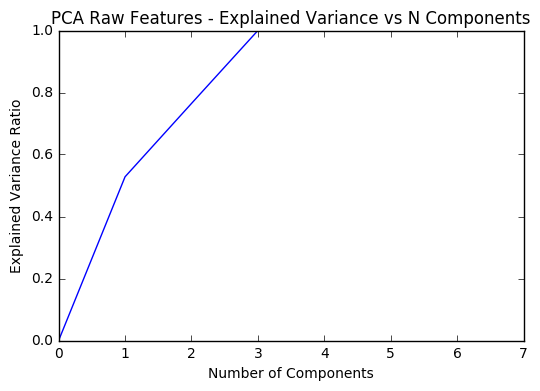

In [25]:
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np
explained=[]
for i in range(len(ft_raw)):
    print i
    pca = PCA(n_components=i)
    pca.fit(train[ft_raw]).transform(train[ft_raw])
    explained.append(np.sum(pca.explained_variance_ratio_))



plt.figure()
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.plot(range(0,len(ft_raw)),explained)
plt.title('PCA Raw Features - Explained Variance vs N Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

Entendendo a dinamica do plot para os dois primeiros PCA

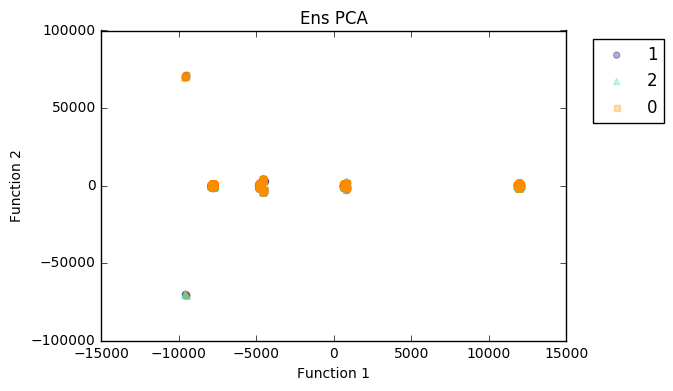

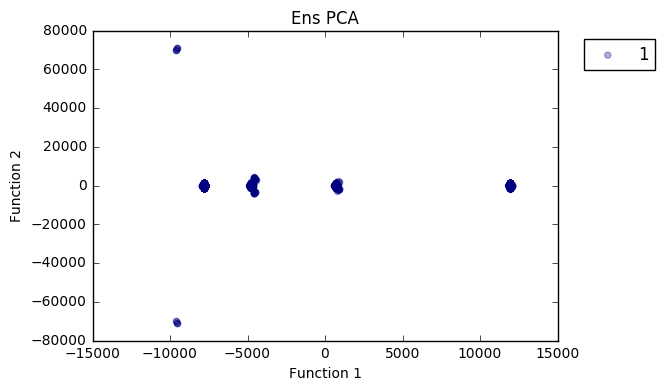

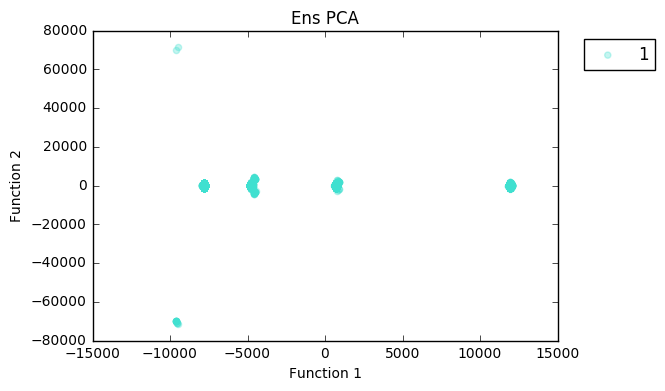

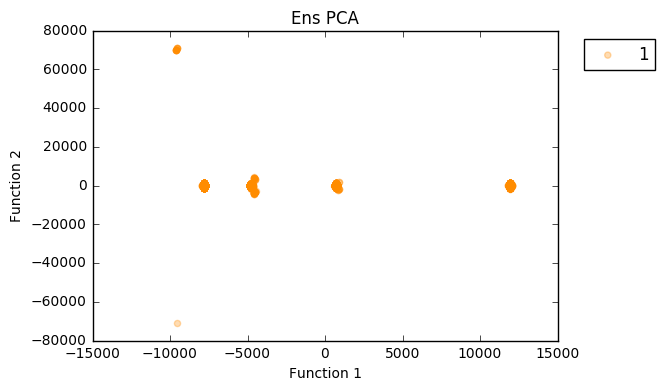

In [26]:
pca_raw = PCA(n_components=2)
X_r2= pca_raw.fit(train[ft_raw]).transform(train[ft_raw])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

pca_raw_train = pca_raw.transform(train[ft_raw])
pca_raw_val = pca_raw.transform(val[ft_raw])
pca_raw_test = pca_raw.transform(test[ft_raw])


plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[train['Output'] == i, 0],X_r2[train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens PCA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[train['Output'] == i, 0],X_r2[train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens PCA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[train['Output'] == i, 0],X_r2[train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens PCA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [2], target_names,["o","^","s"]):
    plt.scatter(X_r2[train['Output'] == i, 0],X_r2[train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens PCA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

In [27]:
logreg_raw_pca,nb_raw_pca,rf_raw_pca,gb_raw_pca,knn_raw_pca = all_algorithms(pca_raw_train,pca_raw_val,pca_raw_test,train['Output'],val['Output'],test['Output'])

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.324108496935 0.30452712183 0.345292955892
Naive Bayes 0.279837690009 0.21241906141 0.443054641211
Random F.   0.404665151515 0.373835277656 0.416721527321
G. Boost.   0.381344066216 0.339174261011 0.428900592495
KNN         0.399521724036 0.37309985889 0.402238314681


Vamos agora usar LDA para raw Features

0
1
2
3
4
5
6
7


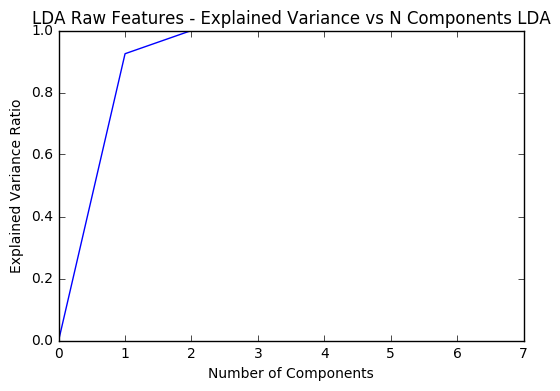

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
explained_lda=[]
for i in range(len(ft_raw)):
    print i
    lda = LinearDiscriminantAnalysis(n_components=i)
    lda.fit(train[ft_raw],train['Output']).transform(train[ft_raw])
    explained_lda.append(np.sum(lda.explained_variance_ratio_))



plt.figure()
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.plot(range(0,len(ft_raw)),explained_lda)
plt.title('LDA Raw Features - Explained Variance vs N Components LDA')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

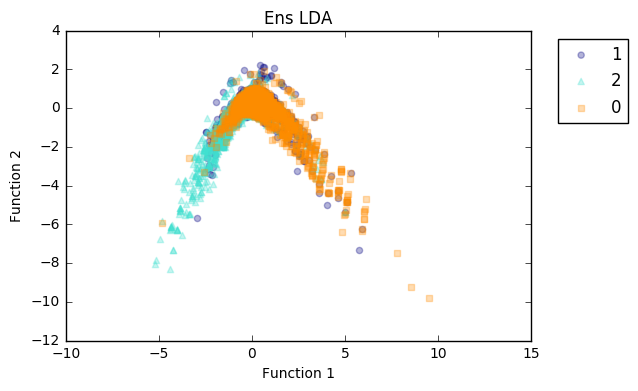

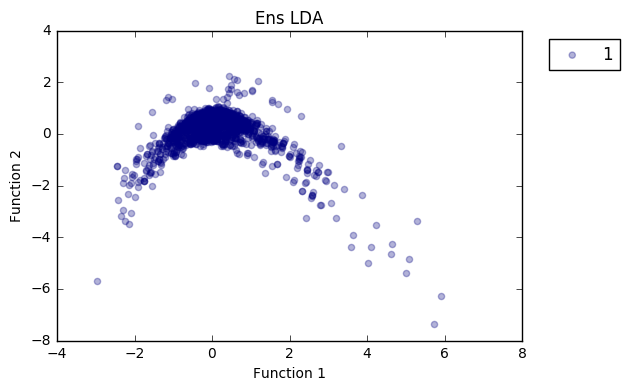

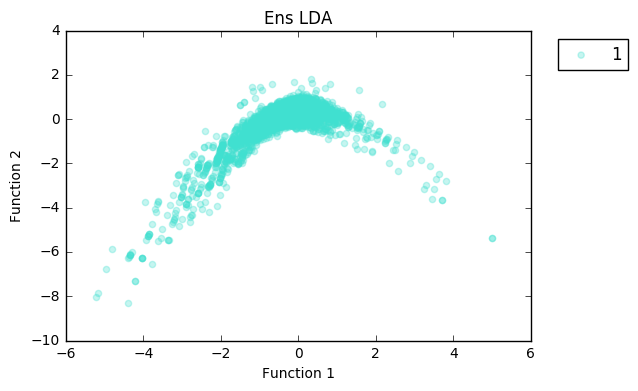

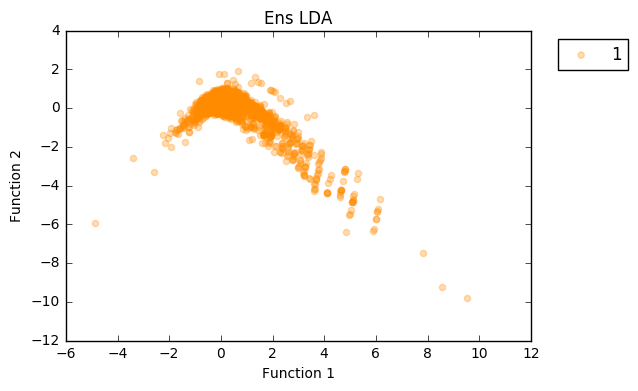

In [30]:
lda_raw = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_raw.fit(train[ft_raw],train['Output']).transform(train[ft_raw])
target_names = ['0','1', '2']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

lda_raw_train = lda_raw.transform(train[ft_raw])
lda_raw_val = lda_raw.transform(val[ft_raw])
lda_raw_test = lda_raw.transform(test[ft_raw])


for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[train['Output'] == i, 0],X_r2[train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[train['Output'] == i, 0],X_r2[train['Output'] == i, 1],alpha=.3, color=color,
                label='0', marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[train['Output'] == i, 0],X_r2[train['Output'] == i, 1],alpha=.3, color=color,
                label='1', marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [ 2], target_names,["o","^","s"]):
    plt.scatter(X_r2[train['Output'] == i, 0],X_r2[train['Output'] == i, 1],alpha=.3, color=color,
                label='2', marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

In [31]:
logreg_raw_lda,nb_raw_lda,rf_raw_lda,gb_raw_lda,knn_raw_lda = all_algorithms(lda_raw_train,lda_raw_val,lda_raw_test,train['Output'],val['Output'],test['Output'])

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.433405587054 0.380974752986 0.516129032258
Naive Bayes 0.4603813482 0.427612404727 0.478933508887
Random F.   0.442696920431 0.414718349377 0.449637919684
G. Boost.   0.463885557776 0.423874158863 0.504608294931
KNN         0.472386328882 0.432922855394 0.510533245556


Vamos agora fazer um sistema de filtragem dos jogos de acordo com a odd da 365

In [33]:
import pandasql as pdsql
pysql = lambda q: pdsql.sqldf(q, globals())
sf_raw_train = pysql("Select * from train where B365H<= 1.5 or B365A<=1.5")
sf_raw_val = pysql("Select * from val where B365H<= 1.5 or B365A<=1.5")
sf_raw_test = pysql("Select * from test where B365H<= 1.5 or B365A<=1.5")

f_raw_train = pysql("Select * from train where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_raw_test = pysql("Select * from test where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_raw_val = pysql("Select * from val where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")

eq_raw_train = pysql("Select * from train where B365H>=2.22 and B365A>=2.22")
eq_raw_val = pysql("Select * from val where B365H>=2.22 and B365A>=2.22")
eq_raw_test = pysql("Select * from test where B365H>=2.22 and B365A>=2.22")

In [35]:
tot_train=[]
print "Super Favorito"
for v in range(len(sf_raw_train[out].value_counts())):
    tot_train.append((sf_raw_train[out].value_counts()[v]*1./np.sum(sf_raw_train[out].value_counts())))
print tot_train
print "Favorito"
tot_val=[]
for v in range(len(f_raw_train['Output'].value_counts())):
    tot_val.append((f_raw_train['Output'].value_counts()[v]*1./np.sum(f_raw_train[out].value_counts())))
print tot_val
print "Equilibrado"
tot_test=[]
for v in range(len(eq_raw_train[out].value_counts())):
    tot_test.append((eq_raw_train[out].value_counts()[v]*1./np.sum(eq_raw_train[out].value_counts())))
print tot_test

Super Favorito
[0.18607856650585802, 0.63266712611991727, 0.18125430737422468]
Favorito
[0.26990821136194493, 0.45919126767551477, 0.2709005209625403]
Equilibrado
[0.30009587727708531, 0.38638542665388304, 0.31351869606903165]


In [39]:
print "Super Favorito Home"
sf_logreg_raw,sf_nb_raw,sf_rf_raw,sf_gb_raw,sf_knn_raw = all_algorithms(sf_raw_train[ft_raw],sf_raw_val[ft_raw],sf_raw_test[ft_raw],sf_raw_train['Output'],sf_raw_val['Output'],sf_raw_test['Output'])
print "Favorito Home"
f_logreg_raw,f_nb_raw,f_rf_raw,f_gb_raw,f_knn_raw = all_algorithms(f_raw_train[ft_raw],f_raw_val[ft_raw],f_raw_test[ft_raw],f_raw_train['Output'],f_raw_val['Output'],f_raw_test['Output'])
print "Equilibrado"
eq_logreg_raw,eq_nb_raw,eq_rf_raw,eq_gb_raw,eq_knn_raw = all_algorithms(eq_raw_train[ft_raw],eq_raw_val[ft_raw],eq_raw_test[ft_raw],eq_raw_train['Output'],eq_raw_val['Output'],eq_raw_test['Output'])

Super Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.488015191921 0.257874015748 0.630818619583
LogReg      0.668677690677 0.509899894275 0.741573033708
Naive Bayes 0.671608895447 0.515956684255 0.741573033708
Random F.   0.668675744728 0.513374869932 0.727126805778
G. Boost.   0.666073681718 0.511888655786 0.730337078652
KNN         0.602678599633 0.449374614089 0.653290529695
Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
libline

In [47]:
import warnings
warnings.filterwarnings("ignore")
filter_raw=[]
for index,row in test.iterrows():
    if row['B365H']<= 1.5 or row['B365A']<= 1.5:
        filter_raw.append(sf_nb_raw.predict(row[ft_raw]))
    elif row['B365H']<= 2.2 or row['B365A']<= 2.2:
        filter_raw.append(f_rf_raw.predict(row[ft_raw]))
    else:
        filter_raw.append(eq_logreg_raw.predict(row[ft_raw]))

print "Filter"
print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
print "Filter.  ", f1_score(test['Output'],filter_raw,average='weighted'),f1_score(test['Output'],filter_raw,average='macro'),f1_score(test['Output'],filter_raw,average='micro')

 Filter
		F1Score	      F1 macro	    F1 micro
Filter.   0.48851223779 0.455052348006 0.510204081633


In [48]:

sf_raw_train_h = pysql("Select * from train where B365H<= 1.5")
sf_raw_val_h = pysql("Select * from val where B365H<= 1.5")
sf_raw_test_h = pysql("Select * from test where B365H<= 1.5")

sf_raw_train_a = pysql("Select * from train where B365A<= 1.5")
sf_raw_val_a = pysql("Select * from val where B365A<= 1.5")
sf_raw_test_a = pysql("Select * from test where B365A<= 1.5")


f_raw_train_h = pysql("Select * from train where (B365H between 1.51 and 2.20)")
f_raw_test_h = pysql("Select * from test where (B365H between 1.51 and 2.20)")
f_raw_val_h = pysql("Select * from val where (B365H between 1.51 and 2.20)")

f_raw_train_a = pysql("Select * from train where (B365A between 1.51 and 2.20)")
f_raw_test_a = pysql("Select * from test where (B365A between 1.51 and 2.20)")
f_raw_val_a = pysql("Select * from val where (B365A between 1.51 and 2.20)")

eq1_raw_train = pysql("Select * from train where B365H>=2.22 and B365A>=2.22")
eq1_raw_test = pysql("Select * from test where B365H>=2.22 and B365A>=2.22")
eq1_raw_val = pysql("Select * from val where B365H>=2.22 and B365A>=2.22")

In [49]:
tot_train=[]
print "Super Favorito Home"
for v in range(len(sf_raw_train_h[out].value_counts())):
    tot_train.append((sf_raw_train_h[out].value_counts()[v]*1./np.sum(sf_raw_train_h[out].value_counts())))
print tot_train
tot_train=[]
print "Super Favorito Away"
for v in range(len(sf_raw_train_a[out].value_counts())):
    tot_train.append((sf_raw_train_a[out].value_counts()[v]*1./np.sum(sf_raw_train_a[out].value_counts())))
print tot_train
print "Favorito Home"
tot_val=[]
for v in range(len(f_raw_train_h['Output'].value_counts())):
    tot_val.append((f_raw_train_h['Output'].value_counts()[v]*1./np.sum(f_raw_train_h[out].value_counts())))
print tot_val
print "Favorito Away"
tot_val=[]
for v in range(len(f_raw_train_a['Output'].value_counts())):
    tot_val.append((f_raw_train_a['Output'].value_counts()[v]*1./np.sum(f_raw_train_a[out].value_counts())))
print tot_val
print "Equilibrado"
tot_test=[]
for v in range(len(eq1_raw_train[out].value_counts())):
    tot_test.append((eq1_raw_train[out].value_counts()[v]*1./np.sum(eq1_raw_train[out].value_counts())))
print tot_test

Super Favorito Home
[0.18166939443535188, 0.7324058919803601, 0.085924713584288048]
Super Favorito Away
[0.20960698689956331, 0.10043668122270742, 0.68995633187772931]
Favorito Home
[0.28002548582351067, 0.52532653711373045, 0.19464797706275885]
Favorito Away
[0.23430493273542602, 0.226457399103139, 0.53923766816143492]
Equilibrado
[0.30009587727708531, 0.38638542665388304, 0.31351869606903165]


In [51]:
print "Super Favorito Home"
sf_logreg_h_raw,sf_nb_h_raw,sf_rf_h_raw,sf_gb_h_raw,sf_knn_h_raw = all_algorithms(sf_raw_train_h[ft_raw],sf_raw_val_h[ft_raw],sf_raw_test_h[ft_raw],sf_raw_train_h['Output'],sf_raw_val_h['Output'],sf_raw_test_h['Output'])
print "Super Favorito Away"
sf_logreg_a_raw,sf_nb_a_raw,sf_rf_a_raw,sf_gb_a_raw,sf_knn_a_raw = all_algorithms(sf_raw_train_a[ft_raw],sf_raw_val_a[ft_raw],sf_raw_test_a[ft_raw],sf_raw_train_a['Output'],sf_raw_val_a['Output'],sf_raw_test_a['Output'])
print "Favorito Home"
f_logreg_h_raw,f_nb_h_raw,f_rf_h_raw,f_gb_h_raw,f_knn_h_raw = all_algorithms(f_raw_train_h[ft_raw],f_raw_val_h[ft_raw],f_raw_test_h[ft_raw],f_raw_train_h['Output'],f_raw_val_h['Output'],f_raw_test_h['Output'])
print "Favorito Away"
f_logreg_a_raw,f_nb_a_raw,f_rf_a_raw,f_gb_a_raw,f_knn_a_raw = all_algorithms(f_raw_train_a[ft_raw],f_raw_val_a[ft_raw],f_raw_test_a[ft_raw],f_raw_train_a['Output'],f_raw_val_a['Output'],f_raw_test_a['Output'])
print "Equilibrado"
eq_logreg_raw,eq_nb_raw,eq_rf_raw,eq_gb_raw,eq_knn_raw = all_algorithms(eq1_raw_train[ft_raw],eq1_raw_val[ft_raw],eq1_raw_test[ft_raw],eq1_raw_train['Output'],eq1_raw_val['Output'],eq1_raw_test['Output'])

Super Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.64020713627 0.285285285285 0.748031496063
LogReg      0.64020713627 0.285285285285 0.748031496063
Naive Bayes 0.443053739479 0.27077530731 0.379921259843
Random F.   0.651375097115 0.306549974024 0.746062992126
G. Boost.   0.64020713627 0.285285285285 0.748031496063
KNN         0.64020713627 0.285285285285 0.748031496063
Super Favorito Away
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblin

In [60]:
filter_raw2=[] 
for index,row in test.iterrows(): 
    if row['B365H']<= 1.5:        
        filter_raw2.append(sf_rf_h_raw.predict(row[ft_raw]))
    elif row['B365A']<= 1.5: 
        filter_raw2.append(sf_logreg_a_raw.predict(row[ft_raw])) 
    elif row['B365H']<= 2.2:
        filter_raw2.append(f_gb_h_raw.predict(row[ft_raw])) 
    elif row['B365A']<= 2.2: 
        filter_raw2.append(f_rf_a_raw.predict(row[ft_raw])) 
    else: 
        filter_raw2.append(eq_logreg_raw.predict(row[ft_raw]))
print "Filter" 
print "\t\tF1Score\t"," F1 macro\t"," F1 micro" 
print "Filter. ", f1_score(test['Output'],filter_raw2,average='weighted'),f1_score(test['Output'],filter_raw2,average='macro'),f1_score(test['Output'],filter_raw2,average='micro')

Filter
		F1Score	 F1 macro	 F1 micro
Filter.  0.488355149195 0.459800787494 0.497695852535


# Importando os dados seguindo o modelo proposto

In [52]:
featured = pd.read_csv('dados2.csv')
featured['Output']=featured.apply(determine_home_result, axis=1)
featured['season']=featured.apply(change_season, axis=1) 

featured= featured.dropna()

import pandasql as pdsql
pysql = lambda q: pdsql.sqldf(q, globals())

#data = pysql("Select * from data where league_id=21518 or league_id= 1729 or league_id=4769 or league_id=10257")

featured = pysql("Select * from featured where league_id=21518 or league_id= 1729 or league_id=4769 or league_id=10257")


from sklearn.feature_selection import chi2

ft=[u'hg_V', u'hg_D', u'hg_E', u'hg_GF', u'hg_AVG_GF', u'hg_GS',
       u'hg_AVG_GS', u'hg_J1GS', u'hg_J1GF', u'hg_BTTS', u'hg_Over2',
       u'hg_Over3', u'hg_Over4', u'hg_WinningCleanSheet', u'hg_LosingFS',
       u'hg_FailedScore', u'hg_CleanSheet', u'hg_AVG_GOALS', u'hgc_V',
       u'hgc_D', u'hgc_E', u'hgc_GF', u'hgc_AVG_GF', u'hgc_GS',
       u'hgc_AVG_GS', u'hgc_J1GS', u'hgc_J1GF', u'hgc_BTTS', u'hgc_Over2',
       u'hgc_Over3', u'hgc_Over4', u'hgc_WinningCleanSheet',
       u'hgc_LosingFS', u'hgc_FailedScore', u'hgc_CleanSheet',
       u'hgc_AVG_GOALS', u'hl_V', u'hl_D', u'hl_E', u'hl_GF', u'hl_AVG_GF',
       u'hl_GS', u'hl_AVG_GS', u'hl_J1GS', u'hl_J1GF', u'hl_BTTS',
       u'hl_Over2', u'hl_Over3', u'hl_Over4', u'hl_WinningCleanSheet',
       u'hl_LosingFS', u'hl_FailedScore', u'hl_CleanSheet',
       u'hl_AVG_GOALS', u'hlc_V', u'hlc_D', u'hlc_E', u'hlc_GF',
       u'hlc_AVG_GF', u'hlc_GS', u'hlc_AVG_GS', u'hlc_J1GS', u'hlc_J1GF',
       u'hlc_BTTS', u'hlc_Over2', u'hlc_Over3', u'hlc_Over4',
       u'hlc_WinningCleanSheet', u'hlc_LosingFS', u'hlc_FailedScore',
       u'hlc_CleanSheet', u'hlc_AVG_GOALS', u'ag_V', u'ag_D', u'ag_E',
       u'ag_GF', u'ag_AVG_GF', u'ag_GS', u'ag_AVG_GS', u'ag_J1GS',
       u'ag_J1GF', u'ag_BTTS', u'ag_Over2', u'ag_Over3', u'ag_Over4',
       u'ag_WinningCleanSheet', u'ag_LosingFS', u'ag_FailedScore',
       u'ag_CleanSheet', u'ag_AVG_GOALS', u'agc_V', u'agc_D', u'agc_E',
       u'agc_GF', u'agc_AVG_GF', u'agc_GS', u'agc_AVG_GS', u'agc_J1GS',
       u'agc_J1GF', u'agc_BTTS', u'agc_Over2', u'agc_Over3', u'agc_Over4',
       u'agc_WinningCleanSheet', u'agc_LosingFS', u'agc_FailedScore',
       u'agc_CleanSheet', u'agc_AVG_GOALS', u'al_V', u'al_D', u'al_E',
       u'al_GF', u'al_AVG_GF', u'al_GS', u'al_AVG_GS', u'al_J1GS',
       u'al_J1GF', u'al_BTTS', u'al_Over2', u'al_Over3', u'al_Over4',
       u'al_WinningCleanSheet', u'al_LosingFS', u'al_FailedScore',
       u'al_CleanSheet', u'al_AVG_GOALS', u'alc_V', u'alc_D', u'alc_E',
       u'alc_GF', u'alc_AVG_GF', u'alc_GS', u'alc_AVG_GS', u'alc_J1GS',
       u'alc_J1GF', u'alc_BTTS', u'alc_Over2', u'alc_Over3', u'alc_Over4',
       u'alc_WinningCleanSheet', u'alc_LosingFS', u'alc_FailedScore',
       u'alc_CleanSheet', u'alc_AVG_GOALS', u'ga_rank_def', u'ga_rank_atk',
       u'gh_rank_def', u'gh_rank_atk', u'la_rank_def', u'la_rank_atk',
       u'lh_rank_def', u'lh_rank_atk', u'a_date', u'h_date', u'stage','B365H','B365D','B365A']

ft_train = featured[featured['season']<=train_value]
ft_val = featured[featured['season']==val_value]
ft_test = featured[featured['season']>=test_value]

In [53]:
logreg_ft,nb_ft,rf_ft,gb_ft,knn_ft = all_algorithms(ft_train[ft],ft_val[ft],ft_test[ft],ft_train['Output'],ft_val['Output'],ft_test['Output'])

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.282856038881 0.207963832377 0.453373768006
LogReg      0.444181175199 0.394008539027 0.505307050796
Naive Bayes 0.452683782475 0.433124880756 0.442380591357
Random F.   0.44732100934 0.395635222153 0.515921152388
G. Boost.   0.460586794094 0.417545444292 0.502274450341
KNN         0.423858642457 0.375846774484 0.482941622441


In [55]:
ft_rank,pvalue = chi2(ft_train[ft],ft_train['Output'])

rank={}
i=0
ft_chi=[]
for v in ft_rank:
    if v>=100:
        rank[i]=v
        
    i=i+1

import operator

sorted_x = sorted(rank.items(), key=operator.itemgetter(1),reverse=True)
selected_ft=[]
for key,value in sorted_x:
    selected_ft.append(ft[key])
    print ft[key],value,pvalue[key]

B365A 1620.85748647 0.0
ag_GF 1133.78926348 6.32105565674e-247
hg_GF 965.768062298 1.93254614536e-210
B365H 789.534340018 3.58753732854e-172
gh_rank_atk 609.384087854 4.71983311232e-133
hgc_GF 517.70595831 3.81574662439e-113
ag_V 516.445386145 7.16653615977e-113
ga_rank_atk 497.436675486 9.61608669394e-109
agc_GF 475.440961002 5.74522554764e-104
gh_rank_def 463.31935187 2.46309442955e-101
hg_V 392.481854088 5.93811031104e-86
hg_GS 379.332186638 4.25659438006e-83
hg_D 377.141098764 1.2730661011e-82
ag_D 344.592480831 1.48831046314e-75
ga_rank_def 338.393957586 3.30130580494e-74
ag_GS 323.305837515 6.23777061227e-71
ag_WinningCleanSheet 310.886392963 3.10368415233e-68
agc_V 292.149658366 3.63502783523e-64
hg_LosingFS 291.63270533 4.70720016607e-64
hg_FailedScore 243.269626861 1.49510508934e-53
ag_LosingFS 234.643803494 1.11620885844e-51
al_GF 221.686426917 7.26781792331e-49
hgc_D 208.737566805 4.71208683872e-46
ag_CleanSheet 203.822193729 5.50266389789e-45
hg_WinningCleanSheet 193.555971

In [56]:
logreg_chi,nb_chi,rf_chi,gb_chi,knn_chi = all_algorithms(ft_train[selected_ft],ft_val[selected_ft],ft_test[selected_ft],ft_train['Output'],ft_val['Output'],ft_test['Output'])

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.282856038881 0.207963832377 0.453373768006
LogReg      0.444312688668 0.391299044447 0.517437452616
Naive Bayes 0.46313610707 0.434025973749 0.462850644428
Random F.   0.459559929656 0.411597345574 0.516679302502
G. Boost.   0.449062907122 0.398489669114 0.511372251706
KNN         0.425432059746 0.375510455479 0.490144048522


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157


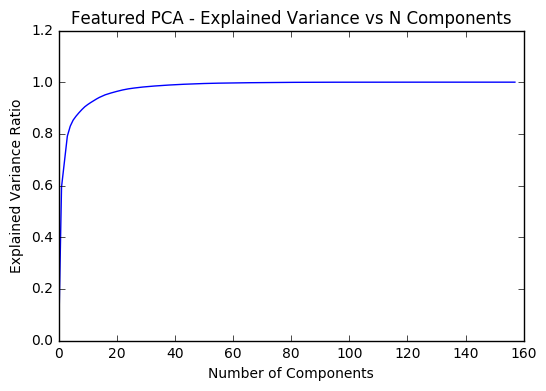

In [61]:
explained=[]
for i in range(len(ft)):
    print i
    pca = PCA(n_components=i)
    pca.fit(ft_train[ft]).transform(ft_train[ft])
    explained.append(np.sum(pca.explained_variance_ratio_))



plt.figure()
plt.legend(bbox_to_anchor=(1.04,1),loc='uplaper left', shadow=False, scatterpoints=1)
plt.plot(range(0,len(ft)),explained)
plt.title('Featured PCA - Explained Variance vs N Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [63]:
pca_ft = PCA(n_components=40)
X_r2= pca_ft.fit(ft_train[ft]).transform(ft_train[ft])
target_names = ['0','1', '2']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

pca_ft_train = pca_ft.transform(ft_train[ft])
pca_ft_val = pca_ft.transform(ft_val[ft])
pca_ft_test = pca_ft.transform(ft_test[ft])


logreg_ft_pca,nb_ft_pca,rf_ft_pca,gb_ft_pca,knn_ft_pca = all_algorithms(pca_ft_train,pca_ft_val,pca_ft_test,ft_train['Output'],ft_val['Output'],ft_test['Output'])


newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.282856038881 0.207963832377 0.453373768006
LogReg      0.453116165505 0.406736563174 0.5
Naive Bayes 0.453796144364 0.413934935774 0.477255496588
Random F.   0.415451230791 0.359100240755 0.501137225171
G. Boost.   0.438246415748 0.396143322229 0.476497346475
KNN         0.427751947175 0.381441095048 0.4806671721


LDA Featured

0
1
2
3
4
5


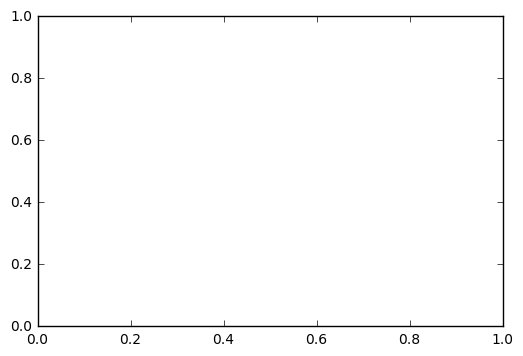

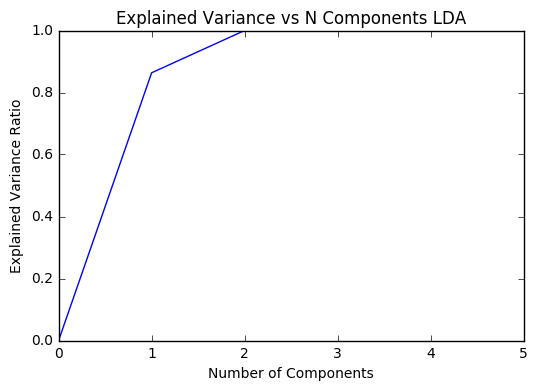

In [69]:
explained_lda=[]
for i in range(6):
    print i
    lda = LinearDiscriminantAnalysis(n_components=i)
    lda.fit(ft_train[ft],ft_train['Output']).transform(ft_train[ft])
    explained_lda.append(np.sum(lda.explained_variance_ratio_))



plt.figure()
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.plot(range(0,6),explained_lda)
plt.title('Explained Variance vs N Components LDA')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

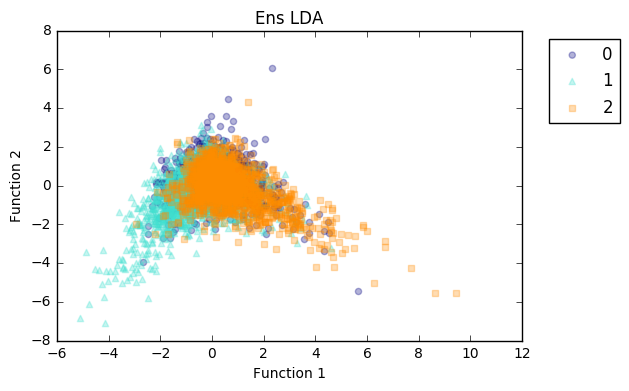

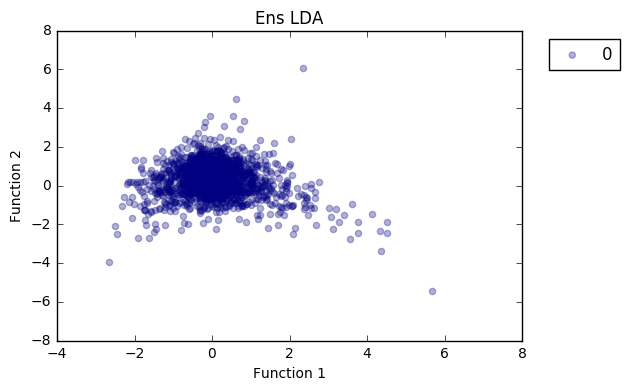

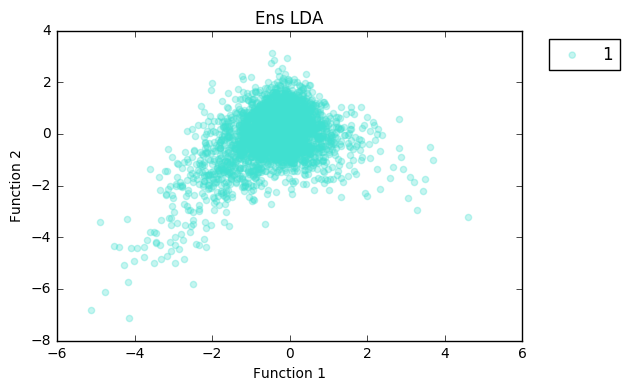

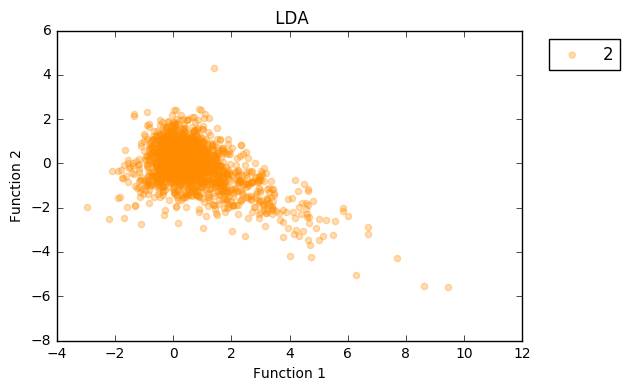

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.282856038881 0.207963832377 0.453373768006
LogReg      0.44589318981 0.396511013158 0.505686125853
Naive Bayes 0.460848325953 0.416831886145 0.498862774829
Random F.   0.436862498262 0.403001782011 0.446929492039
G. Boost.   0.443014274074 0.392462558961 0.502274450341
KNN         0.468480485883 0.425384985912 0.507960576194


In [70]:
lda_ft = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_ft.fit(ft_train[ft],ft_train['Output']).transform(ft_train[ft])
target_names = ['0','1', '2']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

lda_ft_train = lda_ft.transform(ft_train[ft])
lda_ft_val = lda_ft.transform(ft_val[ft])
lda_ft_test = lda_ft.transform(ft_test[ft])


for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[ft_train['Output'] == i, 0],X_r2[ft_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[ft_train['Output'] == i, 0],X_r2[ft_train['Output'] == i, 1],alpha=.3, color=color,
                label='0', marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[ft_train['Output'] == i, 0],X_r2[ft_train['Output'] == i, 1],alpha=.3, color=color,
                label='1', marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [ 2], target_names,["o","^","s"]):
    plt.scatter(X_r2[ft_train['Output'] == i, 0],X_r2[ft_train['Output'] == i, 1],alpha=.3, color=color,
                label='2', marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(' LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

logreg_ft_lda,nb_ft_lda,rf_ft_lda,gb_ft_lda,knn_ft_lda = all_algorithms(lda_ft_train,lda_ft_val,lda_ft_test,ft_train['Output'],ft_val['Output'],ft_test['Output'])


Filtro Featured

In [73]:
sf_ft_train = pysql("Select * from ft_train where B365H<= 1.5 or B365A<=1.5")
sf_ft_val = pysql("Select * from ft_val where B365H<= 1.5 or B365A<=1.5")
sf_ft_test = pysql("Select * from ft_test where B365H<= 1.5 or B365A<=1.5")

f_ft_train = pysql("Select * from ft_train where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_ft_test = pysql("Select * from ft_test where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_ft_val = pysql("Select * from ft_val where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")

eq_ft_train = pysql("Select * from ft_train where B365H>=2.22 and B365A>=2.22")
eq_ft_val = pysql("Select * from ft_val where B365H>=2.22 and B365A>=2.22")
eq_ft_test = pysql("Select * from ft_test where B365H>=2.22 and B365A>=2.22")

In [74]:
print "Super Favorito Home"
sf_logreg_ft,sf_nb_ft,sf_rf_ft,sf_gb_ft,sf_knn_ft = all_algorithms(sf_ft_train[ft],sf_ft_val[ft],sf_ft_test[ft],sf_ft_train['Output'],sf_ft_val['Output'],sf_ft_test['Output'])
print "Favorito Home"
f_logreg_ft,f_nb_ft,f_rf_ft,f_gb_ft,f_knn_ft = all_algorithms(f_ft_train[ft],f_ft_val[ft],f_ft_test[ft],f_ft_train['Output'],f_ft_val['Output'],f_ft_test['Output'])
print "Equilibrado"
eq_logreg_ft,eq_nb_ft,eq_rf_ft,eq_gb_ft,eq_knn_ft = all_algorithms(eq_ft_train[ft],eq_ft_val[ft],eq_ft_test[ft],eq_ft_train['Output'],eq_ft_val['Output'],eq_ft_test['Output'])

Super Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.514361173919 0.263059000376 0.651769087523
LogReg      0.699966726219 0.533468697124 0.769087523277
Naive Bayes 0.673719223588 0.573749957157 0.661080074488
Random F.   0.697142130382 0.529652689538 0.765363128492
G. Boost.   0.698330508788 0.531758825525 0.767225325885
KNN         0.704178387835 0.547852196923 0.750465549348
Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
libline

league_id           1729.00
season                 6.00
stage                  1.00
home_team_api_id    9825.00
away_team_api_id    9826.00
home_team_goal         2.00
away_team_goal         1.00
B365H                  1.25
B365D                  6.50
B365A                 15.00
Output                 1.00
Name: 2280, dtype: float64

In [82]:
import warnings
warnings.filterwarnings("ignore")
filter_ft=[]
for index,row in ft_test.iterrows():
    if row['B365H']<= 1.5 or row['B365A']<= 1.5:
        filter_ft.append(sf_knn_ft.predict(row[ft]))
    elif row['B365H']<= 2.2 or row['B365A']<= 2.2:
        filter_ft.append(f_logreg_ft.predict(row[ft]))
    else:
        filter_ft.append(eq_logreg_ft.predict(row[ft]))

print "Filter"
print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
print "Filter.  ", f1_score(ft_test['Output'],filter_ft,average='weighted'),f1_score(ft_test['Output'],filter_ft,average='macro'),f1_score(ft_test['Output'],filter_ft,average='micro')


 Filter
		F1Score	      F1 macro	    F1 micro
Filter.   0.473196561401 0.432680041063 0.504169825625


Filtro Featured LDA

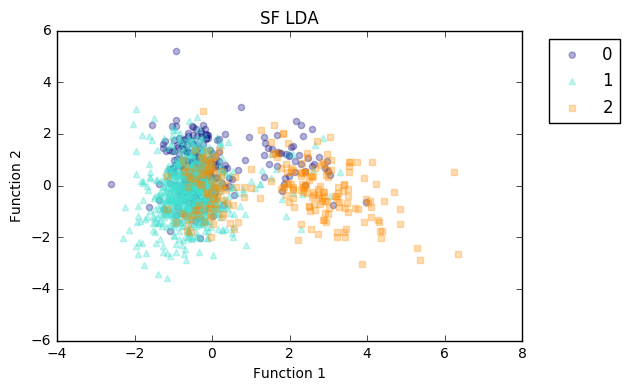

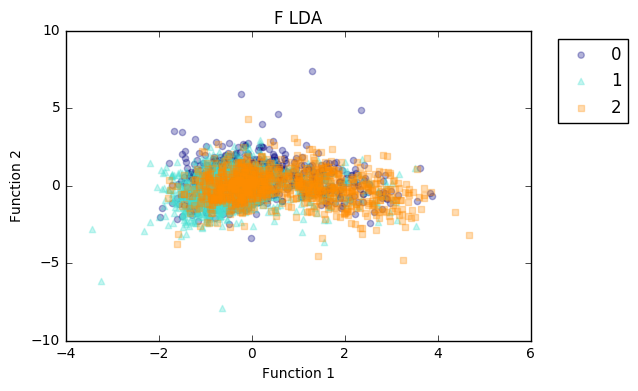

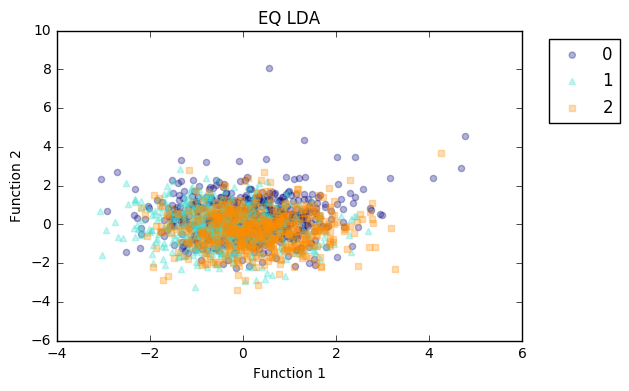

Super Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.514361173919 0.263059000376 0.651769087523
LogReg      0.694201418807 0.529741275019 0.750465549348
Naive Bayes 0.679386739007 0.513043825618 0.722532588454
Random F.   0.670108173724 0.530232406773 0.679702048417
G. Boost.   0.684630623914 0.516471028515 0.731843575419
KNN         0.694541254875 0.535353577185 0.739292364991
Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
libline

In [85]:
lda_ft_lda_sf = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_ft_lda_sf.fit(sf_ft_train[ft],sf_ft_train['Output']).transform(sf_ft_train[ft])
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
sf_train_lda = lda_ft_lda_sf.transform(sf_ft_train[ft])
sf_test_lda = lda_ft_lda_sf.transform(sf_ft_test[ft])
sf_val_lda = lda_ft_lda_sf.transform(sf_ft_val[ft])


plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[sf_ft_train['Output'] == i, 0],X_r2[sf_ft_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('SF LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

lda_ft_lda_f = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_ft_lda_f.fit(f_ft_train[ft],f_ft_train[out]).transform(f_ft_train[ft])
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

f_train_lda = lda_ft_lda_f.transform(f_ft_train[ft])
f_test_lda = lda_ft_lda_f.transform(f_ft_test[ft])
f_val_lda = lda_ft_lda_f.transform(f_ft_val[ft])



plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[f_ft_train['Output'] == i, 0],X_r2[f_ft_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('F LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

lda_ft_lda_eq = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_ft_lda_eq.fit(eq_ft_train[ft],eq_ft_train[out]).transform(eq_ft_train[ft])
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

eq_train_lda = lda_ft_lda_eq.transform(eq_ft_train[ft])
eq_test_lda = lda_ft_lda_eq.transform(eq_ft_test[ft])
eq_val_lda = lda_ft_lda_eq.transform(eq_ft_val[ft])
plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[eq_ft_train['Output'] == i, 0],X_r2[eq_ft_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('EQ LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()


print "Super Favorito Home"
sf_logreg_ft_lda,sf_nb_ft_lda,sf_rf_ft_lda,sf_gb_ft_lda,sf_knn_ft_lda = all_algorithms(sf_train_lda,sf_val_lda,sf_test_lda,sf_ft_train['Output'],sf_ft_val['Output'],sf_ft_test['Output'])
print "Favorito Home"
f_logreg_ft_lda,f_nb_ft_lda,f_rf_ft_lda,f_gb_ft_lda,f_knn_ft_lda = all_algorithms(f_train_lda,f_val_lda,f_test_lda,f_ft_train['Output'],f_ft_val['Output'],f_ft_test['Output'])
print "Equilibrado"
eq_logreg_ft_lda,eq_nb_ft_lda,eq_rf_ft_lda,eq_gb_ft_lda,eq_knn_ft_lda = all_algorithms(eq_train_lda,eq_val_lda,eq_test_lda,eq_ft_train['Output'],eq_ft_val['Output'],eq_ft_test['Output'])


In [ ]:
import warnings
warnings.filterwarnings("ignore")
filter_ft_lda=[]
for index,row in ft_test.iterrows():
    if row['B365H']<= 1.5 or row['B365A']<= 1.5:
        r= lda_ft_lda_sf.transform(row[ft])
        filter_ft_lda.append(sf_knn_ft.predict(r))
    elif row['B365H']<= 2.2 or row['B365A']<= 2.2:
        r = lda_ft_lda_f.transform(row[ft])
        filter_ft_lda.append(f_rf_raw.predict(row[ft_raw]))
    else:
        r= lda_ft_lda_eq.transform(row[ft])
        filter_ft_lda.append(eq_logreg_raw.predict(row[ft_raw]))

print "Filter"
print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
print "Filter.  ", f1_score(ft_test['Output'],filter_ft_lda,average='weighted'),f1_score(ft_test['Output'],filter_ft_lda,average='macro'),f1_score(ft_test['Output'],filter_ft_lda,average='micro')


In [86]:
sf_ft_h_train = pysql("Select * from ft_train where B365H<= 1.5")
sf_ft_h_val = pysql("Select * from ft_val where B365H<= 1.5")
sf_ft_h_test = pysql("Select * from ft_test where B365H<= 1.5")

sf_ft_a_train = pysql("Select * from ft_train where  B365A<=1.5")
sf_ft_a_val = pysql("Select * from ft_val where B365A<=1.5")
sf_ft_a_test = pysql("Select * from ft_test where B365A<=1.5")


f_ft_h_train = pysql("Select * from ft_train where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_ft_h_test = pysql("Select * from ft_test where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_ft_h_val = pysql("Select * from ft_val where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")

f_ft_a_train = pysql("Select * from ft_train where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_ft_a_test = pysql("Select * from ft_test where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_ft_a_val = pysql("Select * from ft_val where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")

eq1_ft_train = pysql("Select * from ft_train where B365H>=2.22 and B365A>=2.22")
eq1_ft_val = pysql("Select * from ft_val where B365H>=2.22 and B365A>=2.22")
eq1_ft_test = pysql("Select * from ft_test where B365H>=2.22 and B365A>=2.22")

In [87]:
print "Super Favorito Home"
sf_logreg_ft_h,sf_nb_ft_h,sf_rf_ft_h,sf_gb_ft_h,sf_knn_ft_h = all_algorithms(sf_ft_h_train[ft],sf_ft_h_val[ft],sf_ft_h_test[ft],sf_ft_h_train['Output'],sf_ft_h_val['Output'],sf_ft_h_test['Output'])
print "Favorito Home"
f_logreg_ft_h,f_nb_ft_h,f_rf_ft_h,f_gb_ft_h,f_knn_ft_h = all_algorithms(f_ft_h_train[ft],f_ft_h_val[ft],f_ft_h_test[ft],f_ft_h_train['Output'],f_ft_h_val['Output'],f_ft_h_test['Output'])
print "Super Favorito Away"
sf_logreg_ft_a,sf_nb_ft_a,sf_rf_ft_a,sf_gb_ft_a,sf_knn_ft_a = all_algorithms(sf_ft_a_train[ft],sf_ft_a_val[ft],sf_ft_a_test[ft],sf_ft_a_train['Output'],sf_ft_a_val['Output'],sf_ft_a_test['Output'])
print "Favorito Away"
f_logreg_ft_a,f_nb_ft_a,f_rf_ft_a,f_gb_ft_a,f_knn_ft_a = all_algorithms(f_ft_a_train[ft],f_ft_a_val[ft],f_ft_a_test[ft],f_ft_a_train['Output'],f_ft_a_val['Output'],f_ft_a_test['Output'])
print "Equilibrado"
eq1_logreg_ft,eq1_nb_ft,eq1_rf_ft,eq1_gb_ft,eq1_knn_ft = all_algorithms(eq1_ft_train[ft],eq1_ft_val[ft],eq1_ft_test[ft],eq1_ft_train['Output'],eq1_ft_val['Output'],eq1_ft_test['Output'])

Super Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.675358332893 0.290862290862 0.77397260274
LogReg      0.675358332893 0.290862290862 0.77397260274
Naive Bayes 0.523921160664 0.34711171978 0.465753424658
Random F.   0.675358332893 0.290862290862 0.77397260274
G. Boost.   0.675358332893 0.290862290862 0.77397260274
KNN         0.684838016534 0.333482509137 0.737442922374
Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 10

In [90]:
filter_ft2=[] 
for index,row in ft_test.iterrows(): 
    if row['B365H']<= 1.5:        
        filter_ft2.append(sf_knn_ft_h.predict(row[ft]))
    elif row['B365A']<= 1.5: 
        filter_ft2.append(sf_logreg_ft_a.predict(row[ft])) 
    elif row['B365H']<= 2.2:
        filter_ft2.append(f_logreg_ft_h.predict(row[ft])) 
    elif row['B365A']<= 2.2: 
        filter_ft2.append(f_logreg_ft_a.predict(row[ft])) 
    else: 
        filter_ft2.append(eq1_logreg_ft.predict(row[ft]))
print "Filter" 
print "\t\tF1Score\t"," F1 macro\t"," F1 micro" 
print "Filter. ", f1_score(ft_test['Output'],filter_ft2,average='weighted'),f1_score(ft_test['Output'],filter_ft2,average='macro'),f1_score(ft_test['Output'],filter_ft2,average='micro')

Filter
		F1Score	 F1 macro	 F1 micro
Filter.  0.472655635208 0.433374912854 0.501137225171


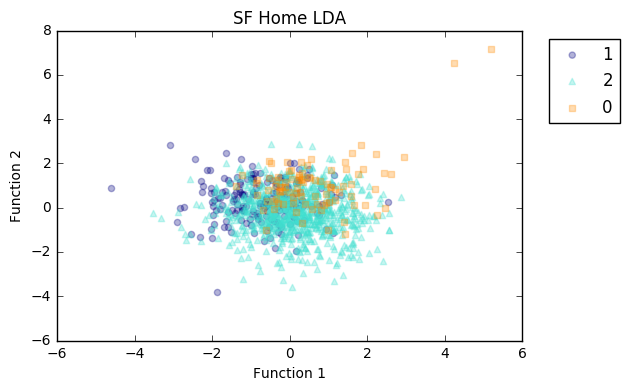

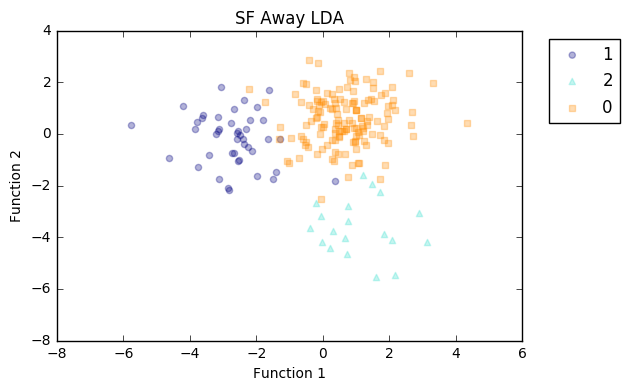

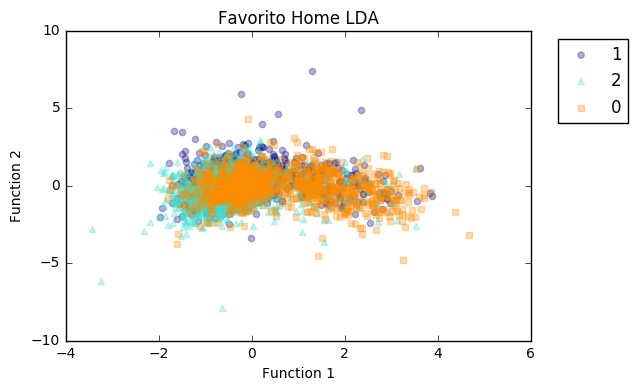

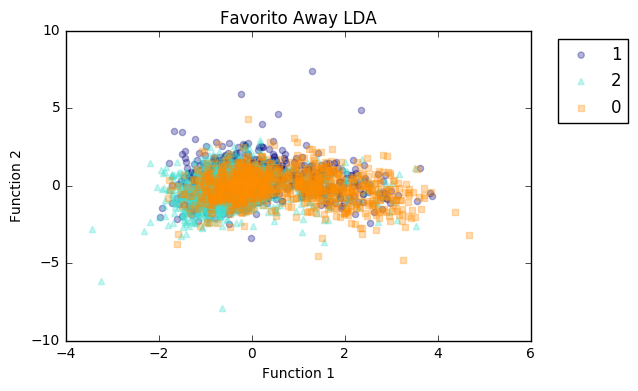

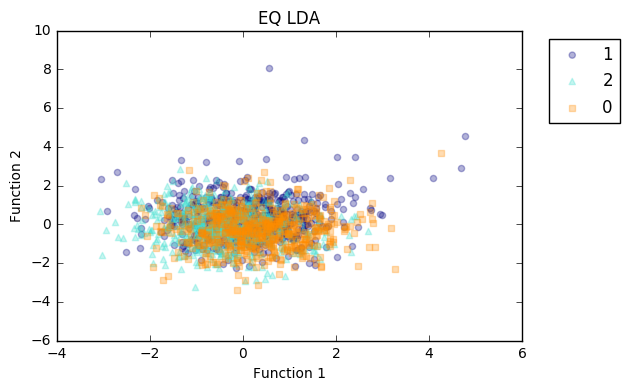

Super Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.675358332893 0.290862290862 0.77397260274
LogReg      0.675358332893 0.290862290862 0.77397260274
Naive Bayes 0.679133699614 0.335842973009 0.728310502283
Random F.   0.674098235023 0.364823518922 0.703196347032
G. Boost.   0.675358332893 0.290862290862 0.77397260274
KNN         0.688263508059 0.338010271615 0.748858447489
Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 

In [95]:
lda2_ft_sf_h = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda2_ft_sf_h.fit(sf_ft_h_train[ft],sf_ft_h_train['Output']).transform(sf_ft_h_train[ft])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
sf_train_h_lda = lda2_ft_sf_h.transform(sf_ft_h_train[ft])
sf_test_h_lda = lda2_ft_sf_h.transform(sf_ft_h_test[ft])
sf_val_h_lda = lda2_ft_sf_h.transform(sf_ft_h_val[ft])

plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[sf_ft_h_train['Output'] == i, 0],X_r2[sf_ft_h_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('SF Home LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()



lda2_ft_sf_a = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda2_ft_sf_a.fit(sf_ft_a_train[ft],sf_ft_a_train['Output']).transform(sf_ft_a_train[ft])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
sf_train_a_lda = lda2_ft_sf_a.transform(sf_ft_a_train[ft])
sf_test_a_lda = lda2_ft_sf_a.transform(sf_ft_a_test[ft])
sf_val_a_lda = lda2_ft_sf_a.transform(sf_ft_a_val[ft])

plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[sf_ft_a_train['Output'] == i, 0],X_r2[sf_ft_a_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('SF Away LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

lda2_ft_f_h = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda2_ft_f_h.fit(f_ft_h_train[ft],f_ft_h_train['Output']).transform(f_ft_h_train[ft])
f_train_h_lda = lda2_ft_f_h.transform(f_ft_h_train[ft])
f_test_h_lda = lda2_ft_f_h.transform(f_ft_h_test[ft])
f_val_h_lda = lda2_ft_f_h.transform(f_ft_h_val[ft])

plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[f_ft_h_train['Output'] == i, 0],X_r2[f_ft_h_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Favorito Home LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()



lda2_ft_f_a = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda2_ft_f_a.fit(f_ft_a_train[ft],f_ft_a_train['Output']).transform(f_ft_a_train[ft])
f_train_a_lda = lda2_ft_f_a.transform(f_ft_a_train[ft])
f_test_a_lda = lda2_ft_f_a.transform(f_ft_a_test[ft])
f_val_a_lda = lda2_ft_f_a.transform(f_ft_a_val[ft])

plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[f_ft_a_train['Output'] == i, 0],X_r2[f_ft_a_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Favorito Away LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()


lda2_ft_eq_1 = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda2_ft_eq_1.fit(eq1_ft_train[ft],eq1_ft_train['Output']).transform(eq1_ft_train[ft])
eq_train_1_lda = lda2_ft_eq_1.transform(eq1_ft_train[ft])
eq_test_1_lda = lda2_ft_eq_1.transform(eq1_ft_test[ft])
eq_val_1_lda = lda2_ft_eq_1.transform(eq1_ft_val[ft])

plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[eq1_ft_train['Output'] == i, 0],X_r2[eq1_ft_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('EQ LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()


print "Super Favorito Home"
sf_logreg_lda2_h,sf_nb_lda2_h,sf_rf_lda2_h,sf_gb_lda2_h,sf_knn_lda2_h = all_algorithms(sf_train_h_lda,sf_val_h_lda,sf_test_h_lda,sf_ft_h_train['Output'],sf_ft_h_val['Output'],sf_ft_h_test['Output'])
print "Favorito Home"
f_logreg_lda2_h,f_nb_lda2_h,f_rf_lda2_h,f_gb_lda2_h,f_knn_lda2_h = all_algorithms(f_train_h_lda,f_val_h_lda,f_test_h_lda,f_ft_h_train['Output'],f_ft_h_val['Output'],f_ft_h_test['Output'])
print "Super Favorito Away"
sf_logreg_lda2_a,sf_nb_lda2_a,sf_rf_lda2_a,sf_gb_lda2_a,sf_knn_lda2_a = all_algorithms(sf_train_a_lda,sf_val_a_lda,sf_test_a_lda,sf_ft_a_train['Output'],sf_ft_a_val['Output'],sf_ft_a_test['Output'])
print "Favorito Away"
f_logreg_lda2_a,f_nb_lda2_a,f_rf_lda2_a,f_gb_lda2_a,f_knn_lda2_a = all_algorithms(f_train_a_lda,f_val_a_lda,f_test_a_lda,f_ft_a_train['Output'],f_ft_a_val['Output'],f_ft_a_test['Output'])
print "Equilibrado"
eq1_logreg_ft,eq1_nb_ft,eq1_rf_ft,eq1_gb_ft,eq1_knn_ft = all_algorithms(eq_train_1_lda,eq_val_1_lda,eq_test_1_lda,eq1_ft_train['Output'],eq1_ft_val['Output'],eq1_ft_test['Output'])


In [97]:
filter_ft_lda2=[] 
for index,row in ft_test.iterrows(): 
    if row['B365H']<= 1.5:
        r = lda2_ft_sf_h.transform(row[ft])
        filter_ft_lda2.append(sf_knn_lda2_h.predict(r))
    elif row['B365A']<= 1.5: 
        r=lda2_ft_sf_a.transform(row[ft])
        filter_ft_lda2.append(sf_logreg_lda2_a.predict(r)) 
    elif row['B365H']<= 2.2:
        r=lda2_ft_f_h.transform(row[ft])
        filter_ft_lda2.append(f_logreg_lda2_h.predict(r)) 
    elif row['B365A']<= 2.2: 
        r=lda2_ft_f_a.transform(row[ft])
        filter_ft_lda2.append(f_logreg_lda2_a.predict(r)) 
    else: 
        r=lda2_ft_eq_1.transform(row[ft])
        filter_ft_lda2.append(eq1_logreg_ft.predict(r))
print "Filter" 
print "\t\tF1Score\t"," F1 macro\t"," F1 micro" 
print "Filter. ", f1_score(ft_test['Output'],filter_ft_lda2,average='weighted'),f1_score(ft_test['Output'],filter_ft_lda2,average='macro'),f1_score(ft_test['Output'],filter_ft_lda2,average='micro')

Filter
		F1Score	 F1 macro	 F1 micro
Filter.  0.474322199147 0.433060375113 0.509097801365


In [ ]:
filter_ft_lda2=[] 
for index,row in ft_test.iterrows(): 
    if row['B365H']<= 1.5:
        r = lda2_ft_sf_h.transform(row[ft])
        filter_ft_lda2.append(sf_knn_lda2_h.predict(r))
    elif row['B365A']<= 1.5: 
        r=lda2_ft_sf_a.transform(row[ft])
        filter_ft_lda2.append(sf_logreg_lda2_a.predict(r)) 
    elif row['B365H']<= 2.2:
        r=lda2_ft_f_h.transform(row[ft])
        filter_ft_lda2.append(f_logreg_lda2_h.predict(r)) 
    elif row['B365A']<= 2.2: 
        r=lda2_ft_f_a.transform(row[ft])
        filter_ft_lda2.append(f_logreg_lda2_a.predict(r)) 
    else: 
        r=lda2_ft_eq_1.transform(row[ft])
        filter_ft_lda2.append(eq1_logreg_ft.predict(r))
print "Filter" 
print "\t\tF1Score\t"," F1 macro\t"," F1 micro" 
print "Filter. ", f1_score(ft_test['Output'],filter_ft_lda2,average='weighted'),f1_score(ft_test['Output'],filter_ft_lda2,average='macro'),f1_score(ft_test['Output'],filter_ft_lda2,average='micro')

['C',
 'GaussianNB',
 'GradientBoostingClassifier',
 'In',
 'IncrementalPCA',
 'KNeighborsClassifier',
 'LinearDiscriminantAnalysis',
 'Out',
 'PCA',
 'RandomForestClassifier',
 'SelectKBest',
 'X_r2',
 '_',
 '_13',
 '_78',
 '_80',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__name__',
 '__package__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i49',
 '_i5',
 '_i50',
 '_i51',
 '_i52',
 '_i53',
 '_i54',
 '_i55',
 '_i56',
 '_i57',
 '_i58',
 '_i59',
 '_i6',
 '_i60',
 '_i61',
 '_i62',
 '_i63',
 '_i64',
 '_i65',
 '_i66',
 '_i67',
 '_i68',
 '_i69',
 '_i7',
 '_i70',
 '_i71',
 '_i72',
 '_i73',
 '_i74',
 '_i75',
 '_i76',
 '_i7

In [100]:
import shelve

filename='./shelve/shelve.out'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: _sh
ERROR shelving: conn
ERROR shelving: exit
ERROR shelving: get_ipython
ERROR shelving: linear_model
ERROR shelving: np
ERROR shelving: operator
ERROR shelving: pd
ERROR shelving: pdsql
ERROR shelving: plt
ERROR shelving: pysql
ERROR shelving: quit
ERROR shelving: random
ERROR shelving: shelve
ERROR shelving: sqlite3
ERROR shelving: warnings
